In [29]:
import csv
import pandas as pd
import xml.etree.ElementTree as et
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
from datetime import datetime as dt

### Leer fichero F24 con datos de un partido reemplazar el nombre aquí

In [30]:
tree = et.ElementTree(file = "f24-23-2018-1009345-eventdetails.xml")
games = tree.getroot()
print(type(games))

<class 'xml.etree.ElementTree.Element'>


In [31]:
match_details = games[0].attrib
match_details

{'id': '1009345',
 'away_score': '1',
 'away_team_id': '957',
 'away_team_name': 'Leganés',
 'competition_id': '23',
 'competition_name': 'Spanish La Liga',
 'game_date': '2018-09-01T19:45:00',
 'home_score': '4',
 'home_team_id': '186',
 'home_team_name': 'Real Madrid',
 'matchday': '3',
 'period_1_start': '2018-09-01T19:45:20',
 'period_2_start': '2018-09-01T20:48:01',
 'season_id': '2018',
 'season_name': 'Season 2018/2019'}

## Squads file

In [32]:
tree3 = et.ElementTree(file = "srml-23-2018-squads.xml")
soccerfeed = tree3.getroot()

In [33]:
player_ids = []
player_names = []

for child in soccerfeed:
    for grchild in child:
        if grchild.tag == "Team":
            for grgrchild in grchild:
                if grgrchild.tag == "Player":
                    player_ids.append(grgrchild.attrib["uID"].lstrip('p'))   
                    #print(grgrchild.attrib["uID"].lstrip('p'))
                    for kchild in grgrchild:
                            if kchild.tag == "Name":
                                player_names.append(kchild.text)
                                #print(kchild.text)
                        
player_dict = dict(zip(player_ids, player_names))

#### Ver los primeros 10 elementos del dicccionario de jugadores

In [34]:
list(player_dict.items())[0:10]

[('91406', 'Fernando Pacheco'),
 ('176245', 'Antonio Sivera'),
 ('439750', 'Álex Domínguez'),
 ('167539', 'Carlos Vigaray'),
 ('126119', 'Rubén Duarte'),
 ('93421', 'Rodrigo Ely'),
 ('49370', 'Víctor Laguardia'),
 ('155335', 'Guillermo Maripán'),
 ('90728', 'Ximo Navarro'),
 ('178873', 'Adrián Marín')]

## Match preview summary

In [39]:
print ("%s v %s, %s %s" % (match_details["home_team_name"],
                          match_details["away_team_name"],
                          match_details["competition_name"][8:],
                          match_details["season_name"][7:]))


print ("Date: %s" % dt.strftime(dt.strptime(match_details["game_date"], '%Y-%m-%dT%H:%M:%S'),
                               "%A %d %B %Y"))

print ("Kick-off: %s" % dt.strftime(dt.strptime(match_details["game_date"], '%Y-%m-%dT%H:%M:%S'),
                               "%I%p").lstrip("0"))

Real Madrid v Leganés, La Liga 2018/2019
Date: Saturday 01 September 2018
Kick-off: 7PM


### Equipos diccionario

In [40]:
team_dict = {match_details["home_team_id"]: match_details["home_team_name"],
             match_details["away_team_id"]: match_details["away_team_name"]}

print (team_dict)

{'186': 'Real Madrid', '957': 'Leganés'}


## Passes

In [41]:
# PASSES

passes_x = []
passes_y = []
passes_outcome = []
passes_min = []
passes_sec = []
passes_period = []
passes_team = []
passes_x_end = []
passes_y_end = []
passes_length = []
passes_angle = []
passes_zone = []
pass_real = []
pass_player = []

for game in games:
    for event in game:
        
        if event.attrib.get("type_id") == '1':
            
            passes_x.append(event.attrib.get("x"))
            passes_y.append(event.attrib.get("y"))
            passes_outcome.append(event.attrib.get("outcome"))
            passes_min.append(event.attrib.get("min"))
            passes_sec.append(event.attrib.get("sec"))
            passes_period.append(event.attrib.get("period_id"))
            passes_team.append(team_dict[event.attrib.get("team_id")])
            pass_player.append(player_dict[event.attrib.get("player_id")])
            
            for q in event:
                
                qualifier = q.attrib.get("qualifier_id")
                
                if qualifier == "140":
                    passes_x_end.append(q.attrib.get("value"))
                if qualifier == "141":
                    passes_y_end.append(q.attrib.get("value"))
                if qualifier == "212":
                    passes_length.append(q.attrib.get("value"))
                if qualifier == "213":
                    passes_angle.append(q.attrib.get("value"))
                if qualifier == "56":
                    passes_zone.append(q.attrib.get("value"))
                    
                             
passes_df = np.array(list(zip(passes_team, pass_player, passes_period, passes_min, passes_sec, passes_zone, passes_x, 
                        passes_y, passes_x_end, passes_y_end, passes_length, passes_angle,passes_outcome)))

print (passes_df)

fieldnames = ["team", "player", "period", "min", "sec", "pass zone", "x", "y", "x_end", "y_end",
              "pass length", "pass angle", "outcome"]

with open("pass_data_%s_%s.csv" % (match_details["home_team_name"], match_details["away_team_name"]),"w",newline='') as passes_csv:
        csv_file = csv.writer(passes_csv)
        csv_file.writerow(fieldnames)
        for i in range(len(passes_df)):
            csv_file.writerow(passes_df[i])

[['Real Madrid' 'Karim Benzema' '1' ... '14.9' '2.7' '1']
 ['Real Madrid' 'Toni Kroos' '1' ... '7.7' '4.6' '1']
 ['Real Madrid' 'Luka Modric' '1' ... '11.3' '1.8' '1']
 ...
 ['Real Madrid' 'Lucas Vázquez' '2' ... '16.8' '1.7' '1']
 ['Real Madrid' 'Dani Ceballos' '2' ... '24.7' '5.4' '1']
 ['Real Madrid' 'Isco' '2' ... '50.9' '1.4' '1']]


In [42]:
passes_df

array([['Real Madrid', 'Karim Benzema', '1', ..., '14.9', '2.7', '1'],
       ['Real Madrid', 'Toni Kroos', '1', ..., '7.7', '4.6', '1'],
       ['Real Madrid', 'Luka Modric', '1', ..., '11.3', '1.8', '1'],
       ...,
       ['Real Madrid', 'Lucas Vázquez', '2', ..., '16.8', '1.7', '1'],
       ['Real Madrid', 'Dani Ceballos', '2', ..., '24.7', '5.4', '1'],
       ['Real Madrid', 'Isco', '2', ..., '50.9', '1.4', '1']],
      dtype='<U17')

In [43]:
passes = pd.DataFrame(passes_df,columns=["team", "player", "period", "min", "sec", "pass zone", "x", "y", "x_end", "y_end",
              "pass length", "pass angle", "outcome"])

In [44]:
passes['period'] = passes['period'].astype('int64')
passes['min'] = passes['min'].astype('int64')
passes['sec'] = passes['sec'].astype('int64')
passes['x'] = passes['x'].astype('float64')
passes['y'] = passes['y'].astype('float64')
passes['x_end'] = passes['x_end'].astype('float64')
passes['y_end'] = passes['y_end'].astype('float64')
passes['pass length'] = passes['pass length'].astype('float64')
passes['pass angle'] = passes['pass angle'].astype('float64')
passes['outcome'] = passes['outcome'].astype('int64')

In [45]:
passes.dtypes

team            object
player          object
period           int64
min              int64
sec              int64
pass zone       object
x              float64
y              float64
x_end          float64
y_end          float64
pass length    float64
pass angle     float64
outcome          int64
dtype: object

In [46]:
passes

,team,player,period,min,sec,pass zone,x,y,x_end,y_end,pass length,pass angle,outcome
0,Real Madrid,Karim Benzema,1,0,1,Back,50.4,49.7,37.6,59.2,14.9,2.7,1
1,Real Madrid,Toni Kroos,1,0,2,Back,38.9,57.1,38.0,45.8,7.7,4.6,1
2,Real Madrid,Luka Modric,1,0,5,Back,32.9,36.9,30.4,53.0,11.3,1.8,1
3,Real Madrid,Casemiro,1,0,6,Back,30.4,53.0,20.7,37.1,14.9,4.0,1
4,Real Madrid,Raphael Varane,1,0,7,Back,20.7,37.1,22.2,7.1,20.5,4.8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199,Real Madrid,Daniel Carvajal,2,93,55,Center,69.7,8.6,94.4,24.6,28.1,0.4,1
1200,Real Madrid,Isco,2,93,58,Center,94.9,26.6,92.9,49.7,15.8,1.7,0
1201,Real Madrid,Lucas Vázquez,2,94,4,Center,77.4,30.4,74.9,54.8,16.8,1.7,1
1202,Real Madrid,Dani Ceballos,2,94,8,Right,73.7,46.7,87.8,17.7,24.7,5.4,1


Filtramos los pases de un jugador Thibaut Courtois

In [57]:
pasesJugador= passes[passes['player'] == "Thibaut Courtois"]
pasesJugador

,team,player,period,min,sec,pass zone,x,y,x_end,y_end,pass length,pass angle,outcome
7,Real Madrid,Thibaut Courtois,1,0,15,Back,6.9,54.6,4.3,27.3,18.8,4.6,1
97,Real Madrid,Thibaut Courtois,1,7,1,Back,21.9,48.2,32.7,77.0,22.6,1.0,1
188,Real Madrid,Thibaut Courtois,1,12,6,Back,4.1,46.9,30.2,74.1,33.1,0.6,1
267,Real Madrid,Thibaut Courtois,1,19,23,Back,12.4,46.4,24.8,58.4,15.4,0.6,1
360,Real Madrid,Thibaut Courtois,1,27,41,Back,13.8,56.3,37.4,73.8,27.5,0.4,1
395,Real Madrid,Thibaut Courtois,1,30,12,Back,14.4,46.9,19.7,71.1,17.4,1.2,1
598,Real Madrid,Thibaut Courtois,1,45,11,Back,7.7,57.3,25.7,81.1,24.9,0.7,1
653,Real Madrid,Thibaut Courtois,2,52,16,Back,3.6,51.5,15.1,18.0,25.8,5.2,1
658,Real Madrid,Thibaut Courtois,2,52,32,Back,6.2,48.8,15.1,24.1,19.2,5.2,1
671,Real Madrid,Thibaut Courtois,2,54,30,Back,14.4,39.4,39.6,95.6,46.5,1.0,1


In [54]:
pasesJugador= pasesJugador.reset_index()
pasesJugador

,index,team,player,period,min,sec,pass zone,x,y,x_end,y_end,pass length,pass angle,outcome
0,7,Real Madrid,Thibaut Courtois,1,0,15,Back,6.9,54.6,4.3,27.3,18.8,4.6,1
1,97,Real Madrid,Thibaut Courtois,1,7,1,Back,21.9,48.2,32.7,77.0,22.6,1.0,1
2,188,Real Madrid,Thibaut Courtois,1,12,6,Back,4.1,46.9,30.2,74.1,33.1,0.6,1
3,267,Real Madrid,Thibaut Courtois,1,19,23,Back,12.4,46.4,24.8,58.4,15.4,0.6,1
4,360,Real Madrid,Thibaut Courtois,1,27,41,Back,13.8,56.3,37.4,73.8,27.5,0.4,1
5,395,Real Madrid,Thibaut Courtois,1,30,12,Back,14.4,46.9,19.7,71.1,17.4,1.2,1
6,598,Real Madrid,Thibaut Courtois,1,45,11,Back,7.7,57.3,25.7,81.1,24.9,0.7,1
7,653,Real Madrid,Thibaut Courtois,2,52,16,Back,3.6,51.5,15.1,18.0,25.8,5.2,1
8,658,Real Madrid,Thibaut Courtois,2,52,32,Back,6.2,48.8,15.1,24.1,19.2,5.2,1
9,671,Real Madrid,Thibaut Courtois,2,54,30,Back,14.4,39.4,39.6,95.6,46.5,1.0,1


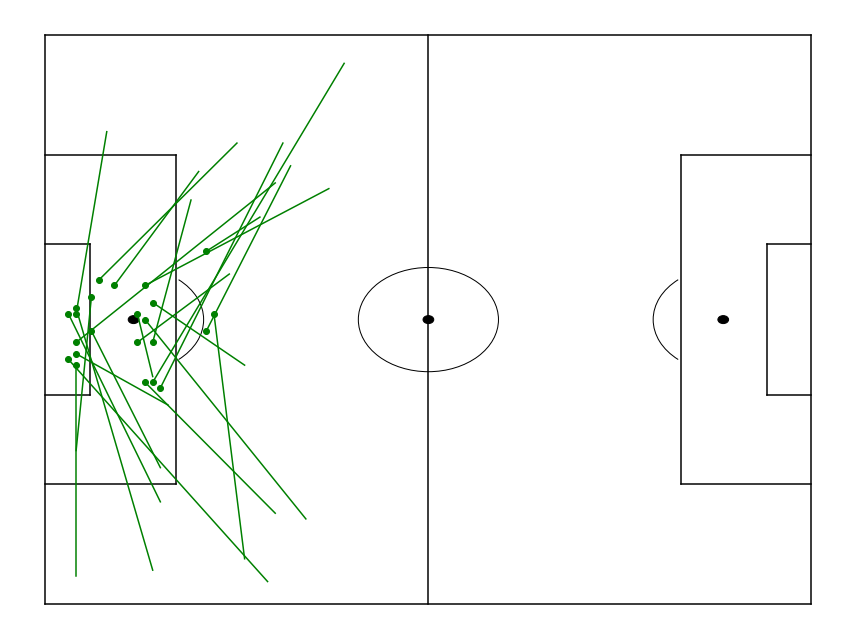

In [56]:
fig=plt.figure()
fig.set_size_inches(12, 9) # Cambiar aqui el tamaño (Ancho, Alto)
ax=fig.add_subplot(1,1,1)

# Pitch Outline & Centre Line OK
plt.plot([0,0],[0,100], color="black")
plt.plot([0,100],[100,100], color="black") #upper line x_start x_end y_start y_end
plt.plot([100,100],[100,0], color="black")
plt.plot([100,0],[0,0], color="black")
plt.plot([50,50],[0,100], color="black")

# Left Penalty Area OK
plt.plot([17,17],[78.9,21.1],color="black")
plt.plot([0,17],[78.9,78.9],color="black")
plt.plot([17,0],[21.1,21.1],color="black")

# Right Penalty Area OK
plt.plot([100,83],[78.9,78.9],color="black")
plt.plot([83,83],[78.9,21.1],color="black")
plt.plot([83,100],[21.1,21.1],color="black")

# Left 6-yard Box on testing
plt.plot([0,5.8],[63.2,63.2],color="black")
plt.plot([5.8,5.8],[63.2,36.8],color="black")
plt.plot([5.8,0],[36.8,36.8],color="black")

# Right 6-yard Box on testing
plt.plot([100,94.2],[63.2,63.2],color="black")
plt.plot([94.2,94.2],[63.2,36.8],color="black")
plt.plot([94.2,100],[36.8,36.8],color="black")

# Prepare Circles OK
centreCircle = plt.Circle((50,50),9.15,color="black",fill=False)
centreSpot = plt.Circle((50,50),0.7,color="black")
leftPenSpot = plt.Circle((11.5,50),0.7,color="black")
rightPenSpot = plt.Circle((88.5,50),0.7,color="black")

# Draw Circles
ax.add_patch(centreCircle)
ax.add_patch(centreSpot)
ax.add_patch(leftPenSpot)
ax.add_patch(rightPenSpot)

# Prepare Arcs based on penalty Spots 
leftArc = Arc((11.5,50),height=18.3,width=18.3,angle=0,theta1=310,theta2=50,color="black")
rightArc = Arc((88.5,50),height=18.3,width=18.3,angle=0,theta1=130,theta2=230,color="black")

# leftArc = Arc((17,50),height=18.3,width=18.3,angle=0,theta1=310,theta2=50,color="blue")
# rightArc = Arc((83,50),height=18.3,width=18.3,angle=0,theta1=130,theta2=230,color="red")

# Draw Arcs
ax.add_patch(leftArc)
ax.add_patch(rightArc)

# Tidy Axes
plt.axis('off')

####################
# PLOT PASSES
####################

for i in range(len(pasesJugador)):
    color = "green" if pasesJugador.iloc[i]['outcome'] == 1 else "red"
    plt.plot([int(pasesJugador["x"][i]),int(pasesJugador["x_end"][i])],
             [int(pasesJugador["y"][i]),int(pasesJugador["y_end"][i])], color=color)
    plt.plot(int(pasesJugador["x"][i]),int(pasesJugador["y"][i]),"o", color=color)


#Display Pitch
plt.tight_layout()
plt.show()

## Goals

In [17]:
# GOALS
goal_x = []
goal_y = []
goal_zone = []
goal_outcome = []
goal_min = []
goal_sec = []
goal_period = []
goal_team = []
goalmouth_y = []
goalmouth_z = []
goal_assisted = []
body_part = []
goal_player = []

body_dict = {"15": "head",
            "72": "left foot",
            "20": "right foot",
            "21": "other body part"}

for game in games:
    for event in game:
        
        if event.attrib.get("type_id") == '16':
            
            goal_x.append(event.attrib.get("x"))
            goal_y.append(event.attrib.get("y"))
            goal_outcome.append(event.attrib.get("outcome"))
            goal_min.append(event.attrib.get("min"))
            goal_sec.append(event.attrib.get("sec"))
            goal_period.append(event.attrib.get("period_id"))
            goal_team.append(team_dict[event.attrib.get("team_id")])
            goal_player.append(player_dict[event.attrib.get("player_id")])
            
            for q in event:
                
                qualifier = q.attrib.get("qualifier_id")
                
                
                if qualifier == "103":
                    goalmouth_z.append(q.attrib.get("value"))
                if qualifier == "102":
                    goalmouth_y.append(q.attrib.get("value"))
                if qualifier == "56":
                    goal_zone.append(q.attrib.get("value"))
                if qualifier in ["15", "72", "20", "21"]:
                    body_part.append(body_dict[qualifier])
                
                
                             
goal_df = np.array(list(zip(goal_team, goal_player, goal_period, goal_min, goal_sec, body_part, goal_zone, goal_x, 
                         goal_y, goalmouth_y, goalmouth_z, goal_outcome)))
print (goal_df)

goal_fieldnames = ["team", "player", "period", "min", "sec", "body part", "zone", "x", "y", 
                   "goalmouth y", "goalmouth z", "outcome"]

with open("goal_data_%s_%s.csv" % (match_details["home_team_name"], match_details["away_team_name"]),"w",newline='') as goal_csv:
        csv_file = csv.writer(goal_csv)
        csv_file.writerow(goal_fieldnames)
        for i in range(len(goal_df)):
            csv_file.writerow(goal_df[i])

[['Real Madrid' 'Gareth Bale' '1' '16' '3' 'right foot' 'Center' '90.0'
  '45.8' '47.3' '21.5' '1']
 ['Leganés' 'Guido Carrillo' '1' '23' '33' 'right foot' 'Center' '88.5'
  '50.0' '45.6' '0.6' '1']
 ['Real Madrid' 'Karim Benzema' '2' '47' '11' 'head' 'Center' '91.1'
  '48.6' '47.4' '5.1' '1']
 ['Real Madrid' 'Karim Benzema' '2' '60' '53' 'right foot' 'Center'
  '84.0' '41.2' '53.5' '1.3' '1']
 ['Real Madrid' 'Sergio Ramos' '2' '65' '55' 'right foot' 'Center' '88.4'
  '50.6' '46.0' '23.4' '1']]


In [18]:
goal = pd.DataFrame(goal_df,columns=["team", "player", "period", "min", "sec", "body part", "zone", "x", "y", 
                   "goalmouth y", "goalmouth z", "outcome"])

In [19]:
goal

,team,player,period,min,sec,body part,zone,x,y,goalmouth y,goalmouth z,outcome
0,Real Madrid,Gareth Bale,1,16,3,right foot,Center,90.0,45.8,47.3,21.5,1
1,Leganés,Guido Carrillo,1,23,33,right foot,Center,88.5,50.0,45.6,0.6,1
2,Real Madrid,Karim Benzema,2,47,11,head,Center,91.1,48.6,47.4,5.1,1
3,Real Madrid,Karim Benzema,2,60,53,right foot,Center,84.0,41.2,53.5,1.3,1
4,Real Madrid,Sergio Ramos,2,65,55,right foot,Center,88.4,50.6,46.0,23.4,1


In [20]:
goal['period'] = goal['period'].astype('int64')
goal['min'] = goal['min'].astype('int64')
goal['sec'] = goal['sec'].astype('int64')
goal['x'] = goal['x'].astype('float64')
goal['y'] = goal['y'].astype('float64')
goal['goalmouth y'] = goal['goalmouth y'].astype('float64')
goal['goalmouth z'] = goal['goalmouth z'].astype('float64')
goal['outcome'] = goal['outcome'].astype('int64')

In [21]:
goal.dtypes

team            object
player          object
period           int64
min              int64
sec              int64
body part       object
zone            object
x              float64
y              float64
goalmouth y    float64
goalmouth z    float64
outcome          int64
dtype: object

## Plot goals

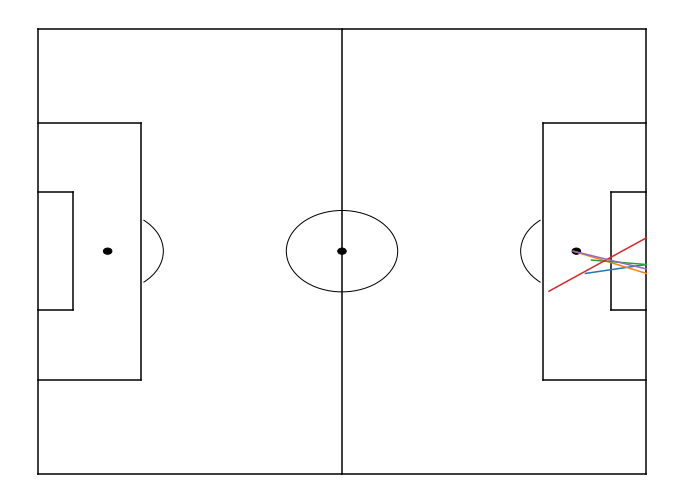

In [22]:
fig=plt.figure()
fig.set_size_inches(12, 9) # Cambiar aqui el tamaño (Ancho, Alto)
ax=fig.add_subplot(1,1,1)

# Pitch Outline & Centre Line OK
plt.plot([0,0],[0,100], color="black")
plt.plot([0,100],[100,100], color="black") #upper line x_start x_end y_start y_end
plt.plot([100,100],[100,0], color="black")
plt.plot([100,0],[0,0], color="black")
plt.plot([50,50],[0,100], color="black")

# Left Penalty Area OK
plt.plot([17,17],[78.9,21.1],color="black")
plt.plot([0,17],[78.9,78.9],color="black")
plt.plot([17,0],[21.1,21.1],color="black")

# Right Penalty Area OK
plt.plot([100,83],[78.9,78.9],color="black")
plt.plot([83,83],[78.9,21.1],color="black")
plt.plot([83,100],[21.1,21.1],color="black")

# Left 6-yard Box on testing
plt.plot([0,5.8],[63.2,63.2],color="black")
plt.plot([5.8,5.8],[63.2,36.8],color="black")
plt.plot([5.8,0],[36.8,36.8],color="black")

# Right 6-yard Box on testing
plt.plot([100,94.2],[63.2,63.2],color="black")
plt.plot([94.2,94.2],[63.2,36.8],color="black")
plt.plot([94.2,100],[36.8,36.8],color="black")

# Prepare Circles OK
centreCircle = plt.Circle((50,50),9.15,color="black",fill=False)
centreSpot = plt.Circle((50,50),0.7,color="black")
leftPenSpot = plt.Circle((11.5,50),0.7,color="black")
rightPenSpot = plt.Circle((88.5,50),0.7,color="black")

# Draw Circles
ax.add_patch(centreCircle)
ax.add_patch(centreSpot)
ax.add_patch(leftPenSpot)
ax.add_patch(rightPenSpot)

# Prepare Arcs based on penalty Spots 
leftArc = Arc((11.5,50),height=18.3,width=18.3,angle=0,theta1=310,theta2=50,color="black")
rightArc = Arc((88.5,50),height=18.3,width=18.3,angle=0,theta1=130,theta2=230,color="black")

# leftArc = Arc((17,50),height=18.3,width=18.3,angle=0,theta1=310,theta2=50,color="blue")
# rightArc = Arc((83,50),height=18.3,width=18.3,angle=0,theta1=130,theta2=230,color="red")

# Draw Arcs
ax.add_patch(leftArc)
ax.add_patch(rightArc)

# Tidy Axes
plt.axis('off')

####################
# PLOT PASSES
####################

for i in range(len(goal)):
    #color = "green" if goal.iloc[i]['outcome'] == 1 else "red"
    plt.plot([int(goal["x"][i]),100],  # LA X final de los goles es la linea de gol x=100
             [int(goal["y"][i]),int(goal["goalmouth y"][i])])
    #plt.plot(int(goal["x"][i]),int(goal["y"][i]),"o")


#Display Pitch
# plt.tight_layout()
plt.show()

## ALL SHOTS

In [23]:
# ALL SHOTS

shot_name = []
shot_x = []
shot_y = []
shot_zone = []
shot_min = []
shot_sec = []
shot_period = []
shot_team = []
goalmouth_y = []
goalmouth_z = []
saved_x = []
saved_y = []
body_part = []
shot_play = []
shot_player = []

shot_dict = {'13': 'Shot off target',
             '14': 'Post',
             '15': 'Shot saved',
             '16': 'Goal'}

body_dict = {"15": "head",
            "72": "left foot",
            "20": "right foot",
            "21": "other body part"}

shot_play_dict = {'22': 'regular play',
            '23': 'fast break',
            '24': 'set piece',
            '25': 'from corner',
            '26': 'free kick',
            '96': 'corner situation',
            '112': 'scramble',
            '160': 'throw-in set piece',
            '9': 'penalty',
            '28': 'own goal'}

for game in games:
    
    for event in game:
        
        if event.attrib.get("type_id") in ['13', '14', '16']:
                    
            shot_name.append(shot_dict[event.attrib.get("type_id")])
            shot_x.append(event.attrib.get("x"))
            shot_y.append(event.attrib.get("y"))
            shot_min.append(event.attrib.get("min"))
            shot_sec.append(event.attrib.get("sec"))
            shot_period.append(event.attrib.get("period_id"))
            shot_team.append(team_dict[event.attrib.get("team_id")])
            shot_player.append(player_dict[event.attrib.get("player_id")])
            
            for q in event:
                
                qualifier = q.attrib.get("qualifier_id")
                if qualifier == '102':
                    saved_x.append('')
                    saved_y.append('')
                    goalmouth_y.append(q.attrib.get("value"))
                if qualifier == '103':
                    goalmouth_z.append(q.attrib.get("value"))
                if qualifier in body_dict.keys():
                    body_part.append(body_dict[qualifier])
                if qualifier in shot_play_dict.keys():
                    shot_play.append(shot_play_dict[qualifier])
                                   
        if event.attrib.get("type_id") == '15':
                    
            shot_name.append(shot_dict[event.attrib.get("type_id")])
            shot_x.append(event.attrib.get("x"))
            shot_y.append(event.attrib.get("y"))
            shot_min.append(event.attrib.get("min"))
            shot_sec.append(event.attrib.get("sec"))
            shot_period.append(event.attrib.get("period_id"))
            shot_team.append(team_dict[event.attrib.get("team_id")])
            shot_player.append(player_dict[event.attrib.get("player_id")])
                        
            
            for q in event:
                
                qualifier = q.attrib.get("qualifier_id")
                if qualifier == '146':
                    goalmouth_y.append('')
                    goalmouth_z.append('')
                    saved_x.append(q.attrib.get("value"))
                if qualifier == '147':
                    saved_y.append(q.attrib.get("value"))
                if qualifier in ["15", "72", "20", "21"]:
                    body_part.append(body_dict[qualifier])
                if qualifier in shot_play_dict.keys():
                    shot_play.append(shot_play_dict[qualifier])
                               
                             
shot_df = np.array(list(zip(shot_team, shot_player, shot_period, shot_min, shot_sec, shot_play, shot_name, body_part, shot_x, shot_y, 
                       goalmouth_y, goalmouth_z, saved_x, saved_y)))
    
# print (shot_df)

shot_fieldnames = ["team", "player", "period", "min", "sec", "shot play", "shot type", "body part", "x", "y", "goalmouth y", 
                   "goalmouth z", "saved x", "saved y"]

with open("shot_data_%s_%s.csv" % (match_details["home_team_name"], match_details["away_team_name"]), 
          "w",newline='') as shot_csv:
        csv_file = csv.writer(shot_csv)
        csv_file.writerow(shot_fieldnames)
        for i in range(len(shot_df)):
            csv_file.writerow(shot_df[i])

In [24]:
shot = pd.DataFrame(shot_df,
columns=["team", "player", "period", "min", "sec", "shot play", "shot type", 
         "body part", "x", "y", "shotmouth y","shotmouth z", "saved x", "saved y"])

In [25]:
shot.head(10)

,team,player,period,min,sec,shot play,shot type,body part,x,y,shotmouth y,shotmouth z,saved x,saved y
0,Real Madrid,Marco Asensio,1,5,1,regular play,Shot off target,left foot,90.7,63.7,49.1,43.1,,
1,Real Madrid,Gareth Bale,1,16,3,regular play,Goal,right foot,90.0,45.8,47.3,21.5,,
2,Real Madrid,Toni Kroos,1,21,3,regular play,Shot saved,right foot,74.3,48.7,,,75.6,48.2
3,Real Madrid,Marco Asensio,1,21,40,regular play,Shot saved,left foot,81.9,43.1,,,82.8,43.3
4,Leganés,Guido Carrillo,1,23,33,penalty,Goal,right foot,88.5,50.0,45.6,0.6,,
5,Leganés,Michael Santos,1,27,36,fast break,Shot saved,right foot,76.0,52.4,,,97.2,50.7
6,Real Madrid,Gareth Bale,1,31,32,regular play,Shot saved,head,91.2,61.8,,,98.5,52.9
7,Leganés,Nabil El Zhar,1,37,5,regular play,Shot saved,right foot,71.7,42.7,,,81.2,45.8
8,Real Madrid,Gareth Bale,1,40,42,regular play,Shot off target,left foot,73.1,35.5,51.9,84.7,,
9,Real Madrid,Karim Benzema,1,41,52,regular play,Shot saved,right foot,96.4,34.7,,,99.1,45.1


In [26]:
shot['period'] = shot['period'].astype('int64')
shot['min'] = shot['min'].astype('int64')
shot['sec'] = shot['sec'].astype('int64')
shot['x'] = shot['x'].astype('float64')
shot['y'] = shot['y'].astype('float64')
shot['shotmouth y'] = pd.to_numeric(shot['shotmouth y'],errors='ignore')
shot['shotmouth z'] = pd.to_numeric(shot['shotmouth z'],errors='ignore')
shot['saved x']     = pd.to_numeric(shot['saved x'],errors='ignore')
shot['saved y']     = pd.to_numeric(shot['saved y'],errors='ignore')

In [27]:
shot.dtypes

team            object
player          object
period           int64
min              int64
sec              int64
shot play       object
shot type       object
body part       object
x              float64
y              float64
shotmouth y    float64
shotmouth z    float64
saved x        float64
saved y        float64
dtype: object

In [28]:
shot.head(10)

,team,player,period,min,sec,shot play,shot type,body part,x,y,shotmouth y,shotmouth z,saved x,saved y
0,Real Madrid,Marco Asensio,1,5,1,regular play,Shot off target,left foot,90.7,63.7,49.1,43.1,NaN,NaN
1,Real Madrid,Gareth Bale,1,16,3,regular play,Goal,right foot,90.0,45.8,47.3,21.5,NaN,NaN
2,Real Madrid,Toni Kroos,1,21,3,regular play,Shot saved,right foot,74.3,48.7,NaN,NaN,75.6,48.2
3,Real Madrid,Marco Asensio,1,21,40,regular play,Shot saved,left foot,81.9,43.1,NaN,NaN,82.8,43.3
4,Leganés,Guido Carrillo,1,23,33,penalty,Goal,right foot,88.5,50.0,45.6,0.6,NaN,NaN
5,Leganés,Michael Santos,1,27,36,fast break,Shot saved,right foot,76.0,52.4,NaN,NaN,97.2,50.7
6,Real Madrid,Gareth Bale,1,31,32,regular play,Shot saved,head,91.2,61.8,NaN,NaN,98.5,52.9
7,Leganés,Nabil El Zhar,1,37,5,regular play,Shot saved,right foot,71.7,42.7,NaN,NaN,81.2,45.8
8,Real Madrid,Gareth Bale,1,40,42,regular play,Shot off target,left foot,73.1,35.5,51.9,84.7,NaN,NaN
9,Real Madrid,Karim Benzema,1,41,52,regular play,Shot saved,right foot,96.4,34.7,NaN,NaN,99.1,45.1
